---
**License**

 FisherMatrixExample

 Tue Jan 19 13:48:00 2021\
 Copyright  2021\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 FisherMatrixExample\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())
obj = None

# Model definition

We define two models below, the abstract class NcModelSimple and its implementation ModelSimpleF that implements a simple function f_x that computes a straight line using two parameters alpha and beta. Most of the code is the boilerplate necessary to connect C and python and do not need to be modified.

In [3]:
mb = Ncm.ModelBuilder.new (Ncm.Model, "NcModelSimple", "A simple python example model")

#              Symbol     Name     Lim inf Lim sup  Scale   Abstol  Default  FREE or FIXED
mb.add_sparam (r'\alpha', 'alpha', -5.0,   5.0,     0.1,    0.0,    2.0,     Ncm.ParamType.FREE)
mb.add_sparam (r'\beta',  'beta',   0.0,   2.0,     0.1,    0.0,    1.0,     Ncm.ParamType.FREE)

if not obj:
    GNcModelSimple = mb.create ()
    obj = GObject.new (GNcModelSimple)
    ModelSimple = GNcModelSimple.pytype
    GObject.type_register (ModelSimple)
pass

class ModelSimpleF (ModelSimple):
    some_property = GObject.Property (type = str)

    def __init__ (self):
        ModelSimple.__init__ (self)
    
    def f_x (self, x):
        return np.exp (self.props.alpha + self.props.beta * x)

GObject.type_register (ModelSimpleF)

pass

# Data model definition

Here we create a likelihood based on a multivariate Gaussian distribution. The most important method to be implemented is do_mean_func, it must compute the theoretical mean $f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$



In [4]:
class DGSimple (Ncm.DataGaussCov):
    # We need one vector property to save the independent variables x
    xv = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)

    def __init__ (self, len = 600):
        Ncm.DataGaussCov.__init__ (self, n_points = len)

        if self.np > 0:
            self.xv = Ncm.Vector.new (self.np)
        else:
            self.xv = None
    
        self.cov_init = False
        if self.np > 0:
            self.cov.set_identity ()
            self.xv.set_zero ()

    def do_get_length (self):
        return self.np
    def do_get_dof (self):
        return self.np
    def do_prepare (self, mset):
        return
    def do_mean_func (self, mset, vp):
        mid = mset.get_id_by_ns ("NcModelSimple")
        mF = mset.peek (mid)

        for i in range (self.np):
            x = self.xv.get (i)
            vp.set (i, mF.f_x (x))

        return

    def create_random_cov (self, slm, rng):
        ya = [slm.f_x (x) for x in self.xv.dup_array ()]
        yv = Ncm.Vector.new_array (ya)

        self.cov.fill_rand_cov2 (yv, 0.1, 0.5, 15.0, rng)

GObject.type_register (DGSimple)
pass

# Creating data

Now we have a data model but no covariance $C_{ij}$ nor data $y_i$. Let's simulate some. First we create a fiducial model. Then, a Likelihood with $15$ points, an uniformly spaced dependent variable vector and a random covariance matrix. We do not need actual data $y_i$ to compute the Fisher matrix, but we create some using resample so we can compare the Fisher and the observed Fisher matrix.

x: 0.000 0.071 0.143 0.214 0.286 0.357 0.429 0.500 0.571 0.643 0.714 0.786 0.857 0.929 1.000
y: 2.167 3.043 2.760 2.659 3.332 3.215 4.390 2.389 2.532 3.619 3.030 2.625 1.162 3.186 3.955
cov: 0.285 0.193 -0.016 -0.003 0.092 -0.058 0.165 -0.064 0.010 -0.009 0.014 0.013 0.031 0.074 -0.038
cov: 0.193 0.835 -0.017 0.034 0.068 -0.034 -0.064 0.133 -0.069 -0.098 0.069 0.072 -0.227 0.092 -0.068
cov: -0.016 -0.017 0.115 0.035 0.010 -0.007 0.063 -0.074 -0.006 0.064 0.017 0.033 0.014 0.009 -0.016
cov: -0.003 0.034 0.035 0.459 0.030 -0.067 -0.011 -0.106 -0.025 -0.037 -0.116 0.010 0.320 0.025 -0.056
cov: 0.092 0.068 0.010 0.030 0.191 0.026 0.187 -0.062 -0.054 0.038 -0.031 0.028 0.062 0.068 -0.006
cov: -0.058 -0.034 -0.007 -0.067 0.026 0.575 -0.130 0.124 -0.063 0.088 -0.012 0.051 -0.142 -0.023 0.067
cov: 0.165 -0.064 0.063 -0.011 0.187 -0.130 1.092 -0.083 -0.031 -0.050 0.066 0.067 -0.053 0.147 -0.062
cov: -0.064 0.133 -0.074 -0.106 -0.062 0.124 -0.083 0.820 -0.071 0.053 -0.056 -0.025 -0.011 0.129 0.0

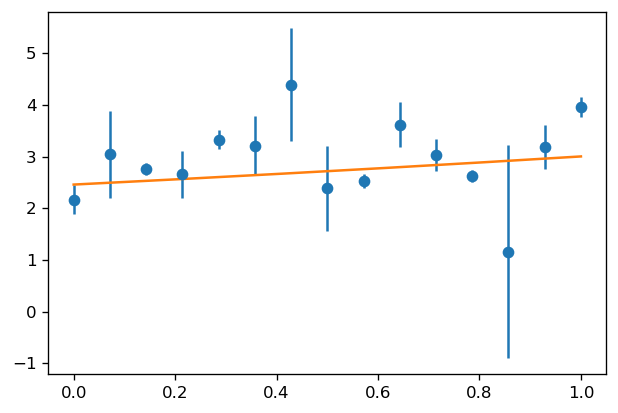

In [5]:
mF = ModelSimpleF ()
mF.props.alpha = 0.9
mF.props.beta  = 0.2

mset = Ncm.MSet.empty_new ()
mset.set (mF)
mset.param_set_all_ftype (Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

rng = Ncm.RNG.seeded_new (None, 123)

dgs = DGSimple (len = 15)
dgs.xv.set_array (np.linspace (0.0, 1.0, dgs.get_size ()))
dgs.create_random_cov (mF, rng)
dgs.resample (mset, rng)

dgs.xv.log_vals ("x: ", "%.3f", True)
dgs.y.log_vals ("y: ", "%.3f", True)
dgs.cov.log_vals ("cov:", "%.3f")

fig = plt.figure (dpi = 120)

x_a = np.linspace (0.0, 1.0, 200)
y_a = mF.f_x (x_a)
cov_d = [dgs.cov.get (i, i) for i in range (15)]

plt.errorbar (dgs.xv.dup_array (), dgs.y.dup_array (), yerr = cov_d, fmt = 'o')
plt.plot (x_a, y_a, '-')

pass

# Creating the fit object

In [6]:
dset = Ncm.Dataset.new ()
dset.append_data (dgs)
lh = Ncm.Likelihood.new (dset)

fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, 
                   Ncm.FitGradType.NUMDIFF_FORWARD)


# Fisher matrix
Finally we can compute the Fisher matrix at the point $\alpha = 0.5$ and $\beta = 0.1$

In [7]:
mF.props.alpha = 0.5
mF.props.beta  = 0.1


fit.fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                 -------------------------------
# alpha[15000:00] =  0.5         +/-  0.1146      |  1           | -0.7948      |
#  beta[15000:01] =  0.1         +/-  0.1769      | -0.7948      |  1           |
#                                                 -------------------------------


# Observed Fisher matrix

Now we can compare it with the observed Fisher matrix. They will differ since the observed fisher matrix only approximate the expected real Fisher matrix at the best fit.

In [8]:
fit.obs_fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                 -------------------------------
# alpha[15000:00] =  0.5         +/-  0.1484      |  1           | -0.6383      |
#  beta[15000:01] =  0.1         +/-  0.2363      | -0.6383      |  1           |
#                                                 -------------------------------


To make them match we first compute the bestfit and then both matrices. Now, the observed Fisher matrix gives a reasonably good approximation.

In [9]:
fit.run (Ncm.FitRunMsgs.SIMPLE)

fit.fisher ()
fit.log_covar ()

fit.obs_fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0097530
#  iteration            [000067]
#  function evaluations [000069]
#  gradient evaluations [000000]
#  degrees of freedom   [000013]
#  m2lnL     =     18.8410081794023 (     18.841008 )
#  Fit parameters:
#     0.901295958415545    0.266390348479092   
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                 -------------------------------
# alpha[15000:00] =  0.9013      +/-  0.07383     |  1           | -0.8169      |
#  beta[15000:01] =  0.2664      +/-  0.1082      | -0.8169      |  1           |
#              